In [1]:
import os
import sys
import glob
import random 
import util
import numpy as np
from random import shuffle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
import nibabel as nib
import nibabel.processing as proc
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from scipy.ndimage import spline_filter
import numpy as np
import matplotlib.pyplot as plt
from custom_image3d1 import *
import interpol
# from numpy import random

In [2]:
import torch
print(torch.__version__)

1.13.0+cu117


In [46]:
# Input image
root_src = "/home/local/VANDERBILT/kanakap/deepN4_data/inputs"
T1s = []
for files in glob.glob(root_src +'/*.nii.gz'):
    T1s.append(files)
T1s.sort()

# Target
root_out = "/home/local/VANDERBILT/kanakap/deepN4_data/labels"
N4_T1s = []
for files in glob.glob(root_out +'/*.nii.gz'):
    N4_T1s.append(files)
N4_T1s.sort()

root_out = "/home/local/VANDERBILT/kanakap/deepN4_data/bias"
bias = []
for files in glob.glob(root_out +'/*.nii.gz'):
    bias.append(files)
bias.sort()

In [47]:
bias[1600]

'/home/local/VANDERBILT/kanakap/deepN4_data/bias/sub-6136_ses-adni3year2scanner041_T1w.nii.gz'

In [49]:
rand = random.sample(range(1, 1500), 100)
len(rand)

100

In [262]:
rand = [28, 64, 80, 90, 55, 35, 9]
train_idx = rand[0:5]
val_idx = rand[5]
test_idx = rand[6]

In [254]:

rand = random.sample((range(1, 500)), 240)
rand
np.savetxt('rand_split2.txt',rand)

In [50]:
train_idx = rand[0:100]
val_idx = rand[100:110]
test_idx = rand[110:120]

In [256]:
with open('btrain_5ds.csv', 'w') as f:
    for i in train_idx:
        f.write("%s,%s\n" % (N4_T1s[i],T1s[i]))
with open('bval_5ds.csv', 'w') as f:
    for i in val_idx:
        f.write("%s,%s\n" % (N4_T1s[i],T1s[i]))
with open('btest_5ds.csv', 'w') as f:
    for i in test_idx:
        f.write("%s,%s\n" % (N4_T1s[i],T1s[i]))

In [51]:
with open('cbtrain_100ds.csv', 'w') as f:
    for i in train_idx:
        f.write("%s,%s,%s\n" % (N4_T1s[i],T1s[i],bias[i]))
with open('cbval_100ds.csv', 'w') as f:
    for i in val_idx:
        f.write("%s,%s,%s\n" % (N4_T1s[i],T1s[i],bias[i]))
with open('cbtest_100ds.csv', 'w') as f:
    for i in test_idx:
        f.write("%s,%s,%s\n" % (N4_T1s[i],T1s[i],bias[i]))

In [258]:
# for raw input images 
def plot_montage(few_files,ax):
    x = 0
    y = 0 
    for z in range(len(few_files)):
        image = nib.load(few_files[z]).get_fdata()
        #image = image[:,:,np.int32(image.shape[2] / 2)]
        image = image[:,:,np.int32(image.shape[2] / 1.7)]
        ax_image = np.squeeze(image)
        ax_image = np.rot90(ax_image,1)
        im = ax[x,y].imshow(ax_image, cmap='gray')
        ax[x,y].set_title(z)
        ax[x,y].axis('off')
        divider = make_axes_locatable(ax[x,y])
        c_ax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im , cax=c_ax)

        if y == 4:
            x += 1
        y += 1
        if y != 0 and y % 5 == 0:
            y = 0

IndexError: index 2 is out of bounds for axis 0 with size 2

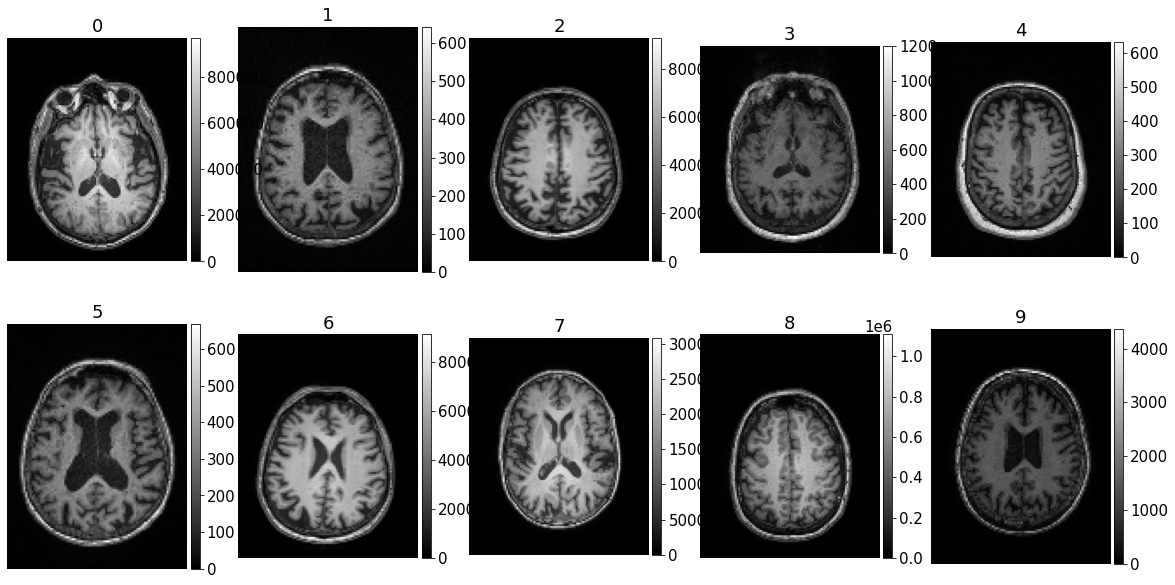

In [259]:
# function call for raw input images 
input_files = []
target_files = []

for i in train_idx:
    input_files.append(T1s[i])
for i in train_idx:
    a = N4_T1s[i].replace('labels','bias')
    target_files.append(a)

fig, ax = plt.subplots(2,5,figsize=(20,10))
plot_montage(input_files + target_files,ax)

In [ ]:
def pad(img, sz):
    tmp = np.zeros((sz, sz, sz))

    diff = int((sz-img.shape[0])/2)
    lx = max(diff,0)
    lX = min(img.shape[0]+diff,sz)

    diff = (img.shape[0]-sz) / 2
    rx = max(int(np.floor(diff)),0)
    rX = min(img.shape[0]-int(np.ceil(diff)),img.shape[0])

    diff = int((sz - img.shape[1]) / 2)
    ly = max(diff, 0)
    lY = min(img.shape[1] + diff, sz)

    diff = (img.shape[1] - sz) / 2
    ry = max(int(np.floor(diff)), 0)
    rY = min(img.shape[1] - int(np.ceil(diff)), img.shape[1])

    diff = int((sz - img.shape[2]) / 2)
    lz = max(diff, 0)
    lZ = min(img.shape[2] + diff, sz)

    diff = (img.shape[2] - sz) / 2
    rz = max(int(np.floor(diff)), 0)
    rZ = min(img.shape[2] - int(np.ceil(diff)), img.shape[2])

    tmp[lx:lX,ly:lY,lz:lZ] = img[rx:rX,ry:rY,rz:rZ]

    return tmp, [lx,lX,ly,lY,lz,lZ,rx,rX,ry,rY,rz,rZ]
    
def normalize_img( img, max_img, min_img, a_max, a_min):

    raw_img = (img - min_img)/(max_img - min_img)
    img = np.clip(raw_img, a_max=a_max, a_min=a_min)
    return img

def transform( img):
    x = random.randint(low=30, high=180)
    rotated = rotate(img, angle=x)
    flip = np.fliplr(rotated)
    return flip

In [ ]:
image = input_data
image = image[:,:,np.int32(image.shape[2] / 1.7)]
ax_image = np.squeeze(image)
ax_image = np.rot90(ax_image,1)
im = ax.imshow(ax_image, cmap='gray')
# ax.set_title(z)
# ax.axis('off')
# divider = make_axes_locatable(ax)
# c_ax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im , cax=c_ax)

In [ ]:
# plot data loader
def plot_montage_data_load(few_files,ax):
    x = 0
    y = 0 
    for z in range(len(few_files)):
        # image = nib.load(few_files[z]).get_fdata()
        image, target = load_both_data(few_files[z])
        image = image[:,:,np.int32(image.shape[2] / 1.7)]
        ax_image = np.squeeze(image)
        ax_image = np.rot90(ax_image,1)
        im = ax[x,y].imshow(ax_image, cmap='gray')
        ax[x,y].set_title(z)
        ax[x,y].axis('off')
        divider = make_axes_locatable(ax[x,y])
        c_ax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im , cax=c_ax)

        target = target[:,:,np.int32(target.shape[2] / 1.7)]
        tx_image = np.squeeze(target)
        tx_image = np.rot90(tx_image,1)
        im = ax[x+1,y].imshow(tx_image, cmap='gray')
        ax[1,y].set_title(z)
        ax[1,y].axis('off')
        divider = make_axes_locatable(ax[1,y])
        c_ax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im , cax=c_ax)

        # if y == 4:
        #     x += 1
        y += 1
        if y != 0 and y % 5 == 0:
            y = 0

In [319]:
import numpy as np

In [324]:
input_data = nib.load(input_target_files[0][0]).get_fdata()
input_data, _ = pad(input_data, 128)
inmax = np.percentile(input_data[np.nonzero(input_data)], 99.99)
input_data = normalize_img(input_data, inmax, 0, 1, 0)
mask_max = np.percentile(input_data[np.nonzero(input_data)], 1)
input_data = input_data > 7.775502841518099e-47

In [310]:
# data loader
from custom_image3d9 import *
def load_both_data(image_file):
    input_data = nib.load(image_file[0]).get_fdata()
    input_data, _ = pad(input_data, 128)
    inmax = np.percentile(input_data[np.nonzero(input_data)], 99.99)
    input_data = normalize_img(input_data, inmax, 0, 1, 0)
    image_transformer = ImageTransformer(rotation_range=90, shift_range=0.,shear_range=0.,zoom_range=0.,crop_size=None,fill_mode='nearest',cval=0.,flip=False, seed=None, return_affine=False, return_affine_params=False, track_flip_number=False, chan_axis=2)
    input_data = image_transformer.random_transform(input_data, passthru=[0])[0]
    input_data = np.squeeze(input_data)
    

    target_data = nib.load(image_file[1]).get_fdata()
    target_data, _ = pad(target_data, 128)
    target_data = normalize_img(target_data, inmax, 0, 1, 0)
    # target_data = image_transformer.random_transform(target_data)[0]
    # input_data = transform(input_data)
    return input_data, target_data


In [222]:
x, y, z = np.deg2rad([60, 60, 60])
print(x, y, z)

1.0471975511965976 1.0471975511965976 1.0471975511965976


1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519943295 1.7453292519943295
1.7453292519943295 1.7453292519

KeyboardInterrupt: 

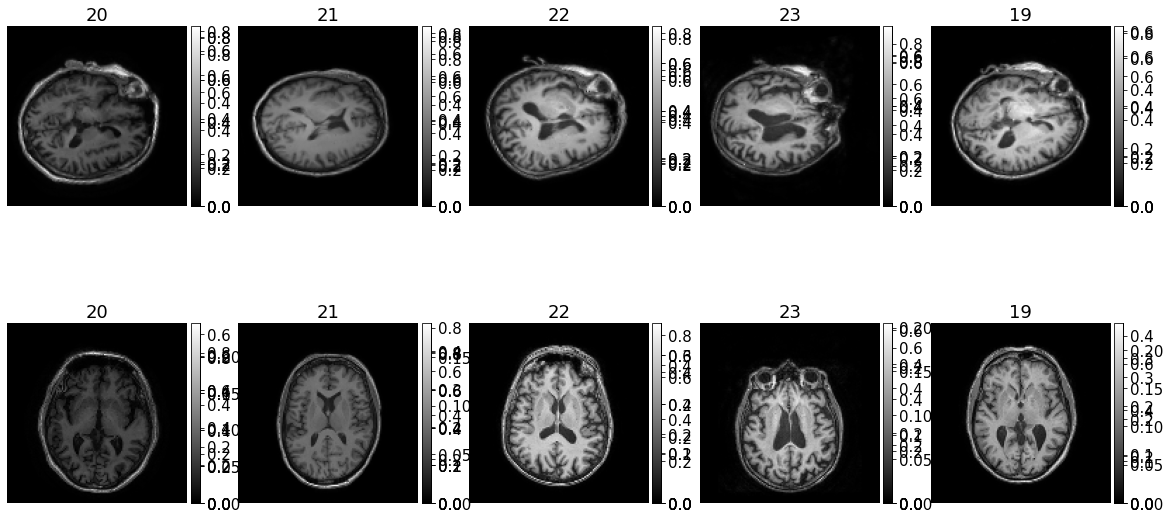

In [315]:
input_target_files = []

for i in train_idx:
    a = T1s[i], N4_T1s[i]
    input_target_files.append(a)

fig, ax = plt.subplots(2,5,figsize=(20,10))

plot_montage_data_load(input_target_files,ax)

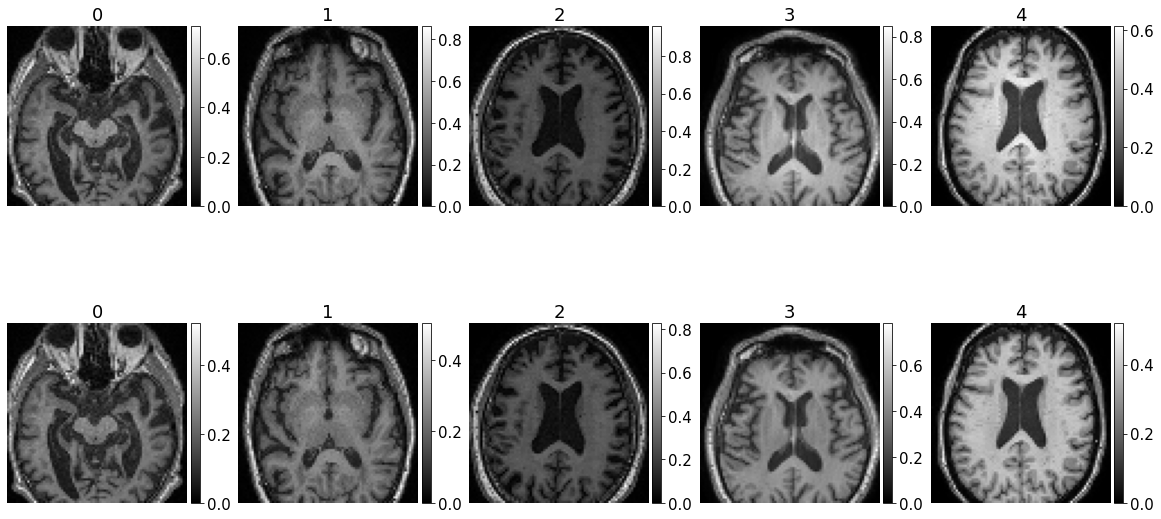

In [249]:
input_target_files = []

for i in train_idx:
    a = T1s[i], N4_T1s[i]
    input_target_files.append(a)

fig, ax = plt.subplots(2,5,figsize=(20,10))

plot_montage_data_load(input_target_files,ax)

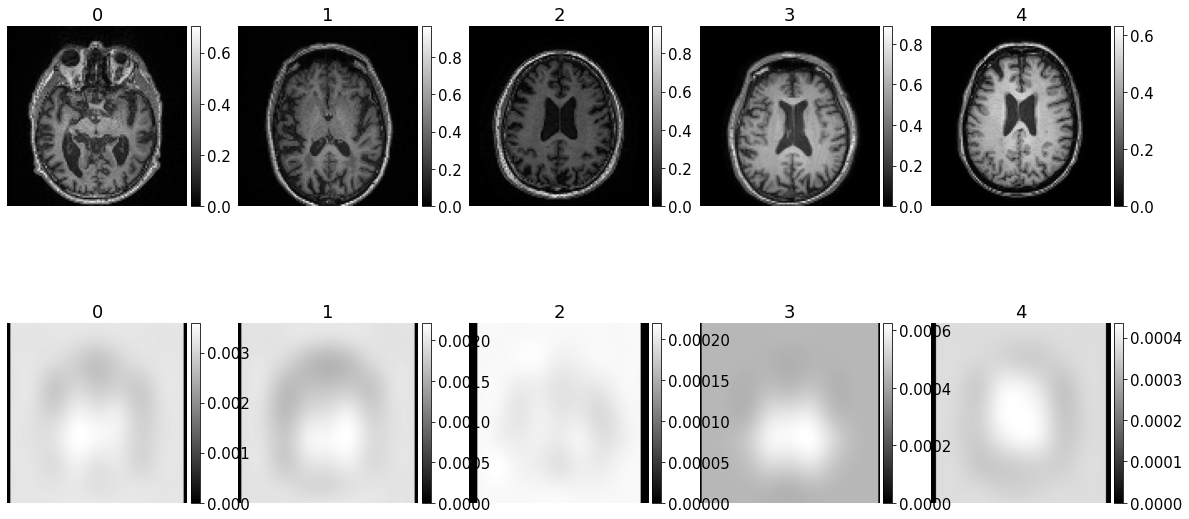

In [55]:
input_target_files = []

for i in train_idx:
    a = T1s[i], N4_T1s[i].replace('labels','bias')
    input_target_files.append(a)

fig, ax = plt.subplots(2,5,figsize=(20,10))

plot_montage_data_load(input_target_files,ax)

In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_3dunet_100data.nii.gz').get_fdata()
pred = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_biasfield_100data.nii.gz').get_fdata()
estimated = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()

In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred0 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_img2imgMNI/pred_3dunet_100data.nii.gz').get_fdata()
estimated = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_img2imgMNI/pred_biasfield_100data.nii.gz').get_fdata()
pred = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()

In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
pred0 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/train_pred_3dunet_32c.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()

In [ ]:
mask1 = mask1.astype(int)
eps = 1e-6
# input1 = np.where(mask1, input1, 0)
# target1 = np.where(mask1, target1, 0)
# pred0 = np.where(mask1, pred0, 0)
estimated_field = (target1 + eps)/(input1 + eps)
predicted_field = (pred0 + eps)/(input1 + eps)
estimated_field = np.where(mask1, estimated_field, 0)
predicted_field = np.where(mask1, predicted_field, 0)
estimated_field.shape

In [ ]:
estimated_field = estimated_field[estimated_field != 0]
estimated_field.shape

In [46]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_3dunet_dividebias_native.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_biasfield_native.nii.gz').get_fdata()


In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logspace2/pred_3dunet_logspace2.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_logspace2/pred_biasfield_logspace2.nii.gz').get_fdata()


In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_auto/pred_3dunet_auto.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_auto/pred_biasfield_auto.nii.gz').get_fdata()


In [28]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_targbias/pred_3dunet_targbias.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_targbias/pred_biasfield_targbias.nii.gz').get_fdata()


In [24]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_targbias/pred_3dunet_targbias.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_targbias/pred_biasfield_targbias.nii.gz').get_fdata()


In [30]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss/pred_3dunet_bothloss.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss/pred_biasfield_bothloss.nii.gz').get_fdata()

In [41]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-4224_ses-adni3baselinescanner082_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-4224_ses-adni3baselinescanner082_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss400_1e-4/pred_3dunet_bothloss400_1e-4.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/bias/sub-4224_ses-adni3baselinescanner082_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss400_1e-4/pred_biasfield_bothloss400_1e-4.nii.gz').get_fdata()

In [81]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss/pred_3dunet_bothloss.nii.gz').get_fdata()
# eps = 1e-6
# estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
estimated_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss/est_biasfield_bothloss.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss/pred_biasfield_bothloss.nii.gz').get_fdata()

# mask = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss/mask_3dunet_bothloss.nii.gz').get_fdata()
# loss = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bothloss/lossmask_3dunet_bothloss.nii.gz').get_fdata()


In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_ae/pred_3dunet_ae.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_ae/pred_biasfield_ae.nii.gz').get_fdata()

In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_ae/pred_3dunet_ae.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0731_ses-adni3year2scanner006_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_ae/train_pred_biasfield_ae.nii.gz').get_fdata()

In [65]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-6136_ses-adni3year2scanner041_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/labels/sub-6136_ses-adni3year2scanner041_T1w.nii.gz').get_fdata()
# mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred1 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bspline/pred_3dunet_bspline.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/bias/sub-6136_ses-adni3year2scanner041_T1w.nii.gz').get_fdata()
predicted_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_bspline/pred_biasfield_bspline.nii.gz').get_fdata()

In [ ]:
target1.shape

/tmp/ipykernel_2024688/3063611467.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,4,1)


1.7911275625228882


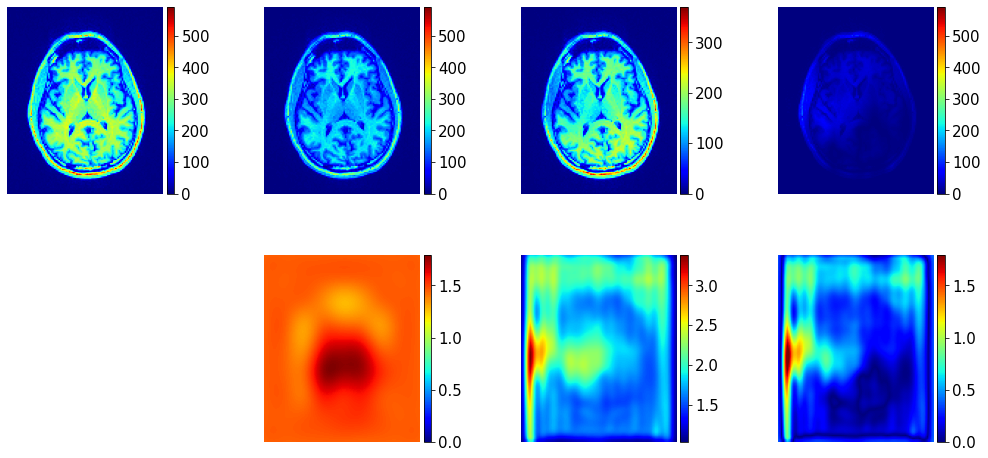

In [68]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(18,8))

slice = input1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(2,4,1)
plt.axis('off')
m = 0
M = np.max(slice)
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = target1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(2,4,2)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = pred1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,3)
plt.axis('off')
im = plt.imshow(np.abs(slice),   cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = pred1 - target1
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,4)
plt.axis('off')
im = plt.imshow(np.abs(slice), vmin=m, vmax=M, cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)


slice = estimated_field
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
m = 0
M = np.max(slice) 
print(np.max(slice))
plt.subplot(2,4,6)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

# predicted_field = spline_filter(predicted_field, order=1)
# predicted_field = torch.Tensor(predicted_field)
# predicted_field = interpol.spline_coeff_nd(predicted_field,interpolation=2,bound='dct2',dim=3,inplace=False)
slice = predicted_field #sp_filter 
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,7)
plt.axis('off')
im = plt.imshow(np.abs(slice),cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = predicted_field - estimated_field #sp_filter - estimated_field#
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(2,4,8)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,cmap='jet')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)
plt.subplots_adjust(wspace=0.1,hspace=0.33)


In [38]:
from scipy.ndimage import gaussian_filter
result = gaussian_filter(predicted_field, sigma=5)

In [39]:
result.shape

(88, 120, 128)

In [18]:
Tpredicted_field.shape

torch.Size([88, 120, 128])

In [10]:
Tpredicted_field = torch.Tensor(predicted_field)

In [ ]:
import math
def fun_rmse(a,b):   
    MSE = np.square(np.subtract(a,b)).mean()
    RMSE = math.sqrt(MSE)
    return RMSE

In [ ]:
fun_rmse(target1,pred1)

In [ ]:
fun_rmse(estimated_field,predicted_field)

In [ ]:
eps = 1e-6
slice = (target1 + eps)/(input1 + eps)

In [ ]:
np.min(slice)

In [111]:
import math
def fun_rmse(a,b):   
    MSE = np.square(np.subtract(a,b)).mean()
    RMSE = math.sqrt(MSE)
    return RMSE


In [ ]:
inputmasked = np.where(mask1,input1,0)
targetmasked = np.where(mask1,target1,0)
predmasked = np.where(mask1,pred0,0)

print(fun_rmse(predmasked,targetmasked))

In [ ]:
input1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
target1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/labels/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
mask1 = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/bet_mask/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred0 = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_3dunet_100data.nii.gz').get_fdata()
# eps = 1e-6
estimated_field = nib.load('/home/local/VANDERBILT/kanakap/downsample_bais_sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
pred_field = nib.load('/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/pred_biasfield_100data.nii.gz').get_fdata()


In [ ]:
fun_rmse(estimated_field,pred_field)

In [ ]:
import scipy.stats
estimated_field[np.isnan(estimated_field)] = 0
estimated_field[np.isinf(estimated_field)] = 0
pred_field[np.isnanee(pred_field)] = 0
pred_field[np.isinf(pred_field)] = 0


a = estimated_field.flatten()
b = pred_field.flatten()
scipy.stats.pearsonr(a,b)

In [ ]:
ref = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data_MNI/inputs/sub-0069_ses-adni2year4scanner100_T1w.nii.gz')
nii = nib.Nifti1Image(estimated_field, affine=ref.affine, header=ref.header)
nib.save(nii, '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/estimated_bias_field.nii.gz')

In [ ]:
raw_in = nib.load('/nfs2/harmonization/BIDS/ADNI_tmp/sub-0069/ses-adni2year4scanner100/anat/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()
raw_out = nib.load('/nfs2/harmonization/BIDS/ADNI_tmp/derivatives/N4BiasFieldCorrection/sub-0069/ses-adni2year4scanner100/anat/sub-0069_ses-adni2year4scanner100_T1w.nii.gz').get_fdata()

In [ ]:
estimated_field = (raw_in)/(raw_out)
ref = nib.load('/nfs2/harmonization/BIDS/ADNI_tmp/sub-0069/ses-adni2year4scanner100/anat/sub-0069_ses-adni2year4scanner100_T1w.nii.gz')
nii = nib.Nifti1Image(estimated_field, affine=ref.affine, header=ref.header)
nib.save(nii, '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model/raw_estimated_bias_field.nii.gz')

In [1]:
d = ['input.nii.gz','corrected.nii.gz','pred_3dunet_img2img.nii.gz','pred_3dunet_img2bias_log.nii.gz','pred_3dunet_bias2bias400.nii.gz','pred_3dunet_bothloss400_1e-4.nii.gz','pred_3dunet_bothloss400_1e-4aug.nii.gz','bias.nii.gz','pred_biasfield_img2img.nii.gz','pred_biasfield_img2bias_log.nii.gz','pred_biasfield_bias2bias400.nii.gz','pred_biasfield_bothloss400_1e-4.nii.gz','pred_biasfield_bothloss400_1e-4aug.nii.gz']

In [62]:
d = ['input.nii.gz','corrected.nii.gz','pred_3dunet_bothloss400_1e-4.nii.gz','pred_3dunet_bothloss400_1e-4aug.nii.gz','pred_3dunet_bothloss400_deep.nii.gz','pred_3dunet_bothloss400_deepaug.nii.gz','pred_3dunet_bspline.nii.gz','pred_3dunet_bspline.nii.gz',

'bias.nii.gz','pred_biasfield_bothloss400_1e-4.nii.gz','pred_biasfield_bothloss400_1e-4aug.nii.gz','pred_biasfield_bothloss400_deep.nii.gz','pred_biasfield_bothloss400_deepaug.nii.gz','pred_biasfield_bspline.nii.gz','pred_biasfield_bspline.nii.gz']

In [87]:
d = ['input.nii.gz','corrected.nii.gz','pred_3dunet_bothloss400_1e-4.nii.gz','pred_3dunet_bothloss400_1e-4aug.nii.gz','pred_3dunet_bothloss400_deep.nii.gz','pred_3dunet_bothloss400_deepaug.nii.gz','pred_3dunet_bspline.nii.gz','pred_3dunet_bspline.nii.gz',

'bias.nii.gz','pred_biasfield_bothloss400_1e-4.nii.gz','pred_biasfield_bothloss400_1e-4aug.nii.gz','pred_biasfield_bothloss400_deep.nii.gz','pred_biasfield_bothloss400_deepaug.nii.gz','pred_biasfield_bspline.nii.gz','pred_biasfield_bspline.nii.gz']

In [105]:
128/2

64.0

/tmp/ipykernel_2666806/1940787169.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,8,i)


1 478.1525573730469 0.0
2 345.8096618652344 0.0
3 318.0401611328125 0.0
4 399.043701171875 0.0
5 270.86199951171875 0.0
6 315.7834777832031 0.0
7 263.18768310546875 0.0
8 263.18768310546875 0.0
10 1.5040923357009888 0.0
11 1.628132939338684 0.0
12 1.2853285074234009 0.0
13 1.812924861907959 0.0
14 1.6085205078125 0.0
15 2.2148349285125732 0.0
16 2.2148349285125732 0.0


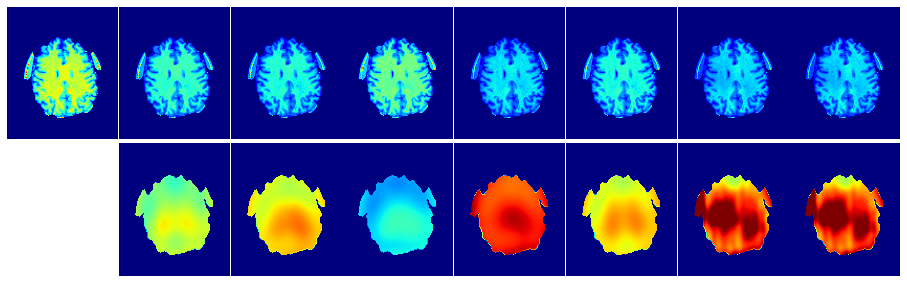

In [94]:
2.89
import sys
import math
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_slice(imagefile,i, r):#, mask):
    slice_idx = 60
    root = '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all/'
    image1 = nib.load(root + imagefile).get_fdata()
    # mask1 = nib.load(root + 'input_bet_mask.nii.gz').get_fdata()
    # slice = np.where(mask1,image,0)
    mask1 = nib.load(root + 'input_bet_mask.nii.gz').get_fdata()
    slice = np.where(mask1,image1,0)
    # predmasked = np.where(mask1,pred1,0)
    # slice = image
    slice = slice[:,:,np.int32(slice.shape[2] / 1.5)]
    slice = np.flip(np.rot90(slice,3))
    slice = np.nan_to_num(slice)
    if i > 8:
        i = i + 1
    plt.subplot(2,8,i)
    plt.axis('off')
    cmap = plt.get_cmap('jet')
    m = r[0]
    M = r[1]
    im = plt.imshow(slice, vmin=m, vmax=M, cmap=cmap)
    print(i, slice.max(), slice.min())

fig, axes = plt.subplots(2,6, figsize=(16,5))
plt.rcParams.update({'font.size':15})


r = [ (0,483),(0,483), (0,483), (0,483), (0,483), (0,483), (0,483), (0,483),
        (0.89,1.82), (0.89,1.82), (0.89,1.82), (0.89,1.82), (0.89,1.82), (0.89,1.82), (0.89,1.82)] # (-1000,-1) at 2

# a = (0.0,65134)
# b = (1.0,2.6)
# r = [ a, a, a, a, a, a, a, a,
#         b, b, b, b, b, b, b] # (-1000,-1) at 2

for i in range(15):
    plot_slice(d[i], i+1, r[i])

plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [89]:
import math
def fun_rmse(a,b):   
    MSE = np.square(np.subtract(a,b)).mean()
    RMSE = math.sqrt(MSE)
    return RMSE

In [106]:
def cal_fun_rmse(tarfile,predfile):
    print(tarfile,predfile)
    root = '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all/'
    tar1 = nib.load(root + tarfile).get_fdata()
    pred1 = nib.load(root + predfile).get_fdata()
    mask1 = nib.load(root + 'input_bet_mask.nii.gz').get_fdata()
    targetmasked = np.where(mask1,tar1,0)
    predmasked = np.where(mask1,pred1,0)
    predmasked = np.nan_to_num(predmasked)
    targetmasked = np.nan_to_num(targetmasked)
    print(fun_rmse(targetmasked,predmasked))

In [80]:
def cal_l1(tarfile,predfile):
    print(tarfile,predfile)
    root = '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all/'
    tar1 = nib.load(root + tarfile).get_fdata()
    pred1 = nib.load(root + predfile).get_fdata()
    mask1 = nib.load(root + 'input_bet_mask.nii.gz').get_fdata()
    targetmasked = np.where(mask1,tar1,0)
    predmasked = np.where(mask1,pred1,0)
    print(np.nanmean(np.abs(targetmasked - predmasked)))

In [184]:
def cohend(c0,c1):
    cohens_d = (np.nanmean(c0) - np.nanmean(c1)) / (np.sqrt((np.nanstd(c0) ** 2 + np.nanstd(c1) ** 2) / 2))
    return cohens_d

In [81]:
from skimage.metrics import structural_similarity as ssim
def cal_fun_ssim(tarfile,predfile):
    print(tarfile,predfile)
    root = '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all/'
    tar1 = nib.load(root + tarfile).get_fdata()
    pred1 = nib.load(root + predfile).get_fdata()
    mask1 = nib.load(root + 'input_bet_mask.nii.gz').get_fdata()
    targetmasked = np.where(mask1,tar1,0)
    predmasked = np.where(mask1,pred1,0)
    print(ssim(targetmasked,predmasked))

In [25]:
import numpy as np

def psnr(originalf, reconstructedf):
    root = '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all/'
    original = nib.load(root + originalf).get_fdata()
    reconstructed = nib.load(root + reconstructedf).get_fdata()
    print(original, reconstructed)
    # Ensure that the images have the same dtype
    original = original.astype(np.float)
    reconstructed = reconstructed.astype(np.float)
    # Calculate MSE
    mse = np.mean((original - reconstructed)**2)
    # Calculate MAX
    max_value = np.max(original)
    # Calculate PSNR
    psnr = 10 * np.log10(max_value**2 / mse)

    return psnr

In [126]:
def plot_slice(image1,image2):
    plt.rcParams.update({'font.size':15})
    fig, ax = plt.subplots(figsize=(4,4))

    slice = image1
    slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
    slice = np.flip(np.rot90(slice,3))
    slice = np.nan_to_num(slice)
    plt.subplot(1,2,1)
    plt.axis('off')
    m = 0
    M = np.max(slice)
    im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='jet')
    divider = make_axes_locatable(plt.gca())
    ax = divider.append_axes("right", size="5%", pad=0.05)
    a = plt.colorbar(im, cax=ax)

    slice = image2
    slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
    slice = np.flip(np.rot90(slice,3))
    slice = np.nan_to_num(slice)
    plt.subplot(1,2,2)
    plt.axis('off')
    im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap='jet')
    divider = make_axes_locatable(plt.gca())
    ax = divider.append_axes("right", size="5%", pad=0.05)
    a = plt.colorbar(im, cax=ax)

In [133]:
def calc_ape(corpt_fa,true_fa):
    err_fa = corpt_fa - true_fa
    pe_fa =  (err_fa / true_fa) * 100
    ape_fa = np.abs(pe_fa)
    ape_fa[np.isnan(ape_fa)] = 0
    ape_fa[np.isinf(ape_fa)] = 0
    mask = np.logical_not(np.logical_or(np.isnan(ape_fa), np.isinf(ape_fa)))
    mape_fa = np.mean(ape_fa[mask])
    return mape_fa
def cal_fun_ape(tarfile,predfile):
    print(tarfile,predfile)
    root = '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all/'
    tar1 = nib.load(root + tarfile).get_fdata()
    pred1 = nib.load(root + predfile).get_fdata()
    mask1 = nib.load(root + 'input_bet_mask.nii.gz').get_fdata()
    targetmasked = np.where(mask1,tar1,0)
    predmasked = np.where(mask1,pred1,0)
    plot_slice(targetmasked,predmasked)
    targetmasked = np.nan_to_num(targetmasked)
    predmasked = np.nan_to_num(predmasked)
    print(calc_ape(targetmasked,predmasked))

corrected.nii.gz pred_3dunet_bothloss400_1e-4.nii.gz


/tmp/ipykernel_2666806/3470641321.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_2666806/4142787121.py:3: RuntimeWarning: divide by zero encountered in true_divide
  pe_fa =  (err_fa / true_fa) * 100
/tmp/ipykernel_2666806/4142787121.py:3: RuntimeWarning: invalid value encountered in true_divide
  pe_fa =  (err_fa / true_fa) * 100


2.5199621205112077
corrected.nii.gz pred_3dunet_bothloss400_1e-4aug.nii.gz
3.8358321269999585
corrected.nii.gz pred_3dunet_bothloss400_deep.nii.gz
3.3471430604572454
corrected.nii.gz pred_3dunet_bothloss400_deepaug.nii.gz
1.6759435705222907
corrected.nii.gz pred_3dunet_bspline.nii.gz
10.327779739606573


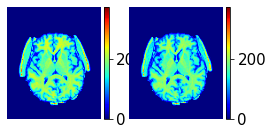

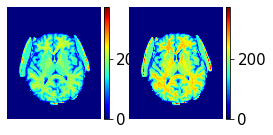

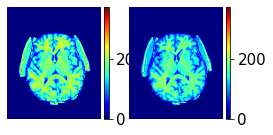

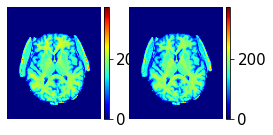

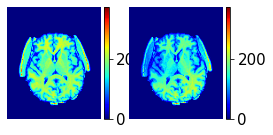

In [134]:
cal_fun_ape(d[1],d[2])
cal_fun_ape(d[1],d[3])
cal_fun_ape(d[1],d[4])
cal_fun_ape(d[1],d[5])
cal_fun_ape(d[1],d[6])

bias.nii.gz pred_biasfield_bothloss400_1e-4.nii.gz


/tmp/ipykernel_2666806/3470641321.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_2666806/4142787121.py:3: RuntimeWarning: invalid value encountered in true_divide
  pe_fa =  (err_fa / true_fa) * 100


24.668303491831487
bias.nii.gz pred_biasfield_bothloss400_1e-4aug.nii.gz
4.915779729259854
bias.nii.gz pred_biasfield_bothloss400_deep.nii.gz
2.996141269975809
bias.nii.gz pred_biasfield_bothloss400_deepaug.nii.gz
1.7122366736543366
bias.nii.gz pred_biasfield_bspline.nii.gz
6.346661449494857


/tmp/ipykernel_2666806/4142787121.py:3: RuntimeWarning: divide by zero encountered in true_divide
  pe_fa =  (err_fa / true_fa) * 100


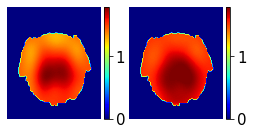

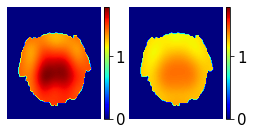

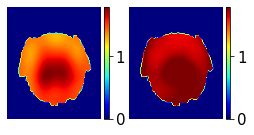

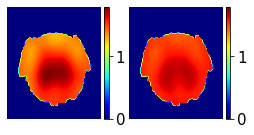

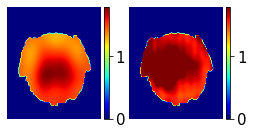

In [135]:
cal_fun_ape(d[8],d[9])
cal_fun_ape(d[8],d[10])
cal_fun_ape(d[8],d[11])
cal_fun_ape(d[8],d[12])
cal_fun_ape(d[8],d[13])

In [85]:
cal_fun_ssim(d[1],d[2])
cal_fun_ssim(d[1],d[3])
cal_fun_ssim(d[1],d[4])
cal_fun_ssim(d[1],d[5])
cal_fun_ssim(d[1],d[6])

corrected.nii.gz pred_3dunet_bothloss400_1e-4.nii.gz
0.9629737557935102
corrected.nii.gz pred_3dunet_bothloss400_1e-4aug.nii.gz
0.9853712338745721
corrected.nii.gz pred_3dunet_bothloss400_deep.nii.gz
0.9883532398905098
corrected.nii.gz pred_3dunet_bothloss400_deepaug.nii.gz
0.9946060518465693
corrected.nii.gz pred_3dunet_bspline.nii.gz
nan


In [105]:
# image 
cal_fun_rmse(d[1],d[2])
cal_fun_rmse(d[1],d[3])
cal_fun_rmse(d[1],d[4])
cal_fun_rmse(d[1],d[5])
cal_fun_rmse(d[1],d[6])

corrected.nii.gz pred_3dunet_bothloss400_1e-4.nii.gz
25.087733133348863
corrected.nii.gz pred_3dunet_bothloss400_1e-4aug.nii.gz
19.226948515409767
corrected.nii.gz pred_3dunet_bothloss400_deep.nii.gz
13.495839681391733
corrected.nii.gz pred_3dunet_bothloss400_deepaug.nii.gz
10.690941189852506
corrected.nii.gz pred_3dunet_bspline.nii.gz
nan


In [87]:
# bias 
cal_fun_ssim(d[8],d[9])
cal_fun_ssim(d[8],d[10])
cal_fun_ssim(d[8],d[11])
cal_fun_ssim(d[8],d[12])
cal_fun_ssim(d[8],d[13])

bias.nii.gz pred_biasfield_bothloss400_1e-4.nii.gz
0.9546186295736272
bias.nii.gz pred_biasfield_bothloss400_1e-4aug.nii.gz
0.981152474798263
bias.nii.gz pred_biasfield_bothloss400_deep.nii.gz
0.9746101806182869
bias.nii.gz pred_biasfield_bothloss400_deepaug.nii.gz
0.9849645192311834
bias.nii.gz pred_biasfield_bspline.nii.gz
0.8673541679315254


In [92]:
cal_fun_rmse(d[8],d[9])
cal_fun_rmse(d[8],d[10])
cal_fun_rmse(d[8],d[11])
cal_fun_rmse(d[8],d[12])
cal_fun_rmse(d[8],d[13])

bias.nii.gz pred_biasfield_bothloss400_1e-4.nii.gz
0.18713881468021215
bias.nii.gz pred_biasfield_bothloss400_1e-4aug.nii.gz
0.1266477869227208
bias.nii.gz pred_biasfield_bothloss400_deep.nii.gz
0.10951062650255532
bias.nii.gz pred_biasfield_bothloss400_deepaug.nii.gz
0.059604823388069716
bias.nii.gz pred_biasfield_bspline.nii.gz
0.39476182211372063


In [93]:
cal_fun_ape(d[8],d[9])
cal_fun_ape(d[8],d[10])
cal_fun_ape(d[8],d[11])
cal_fun_ape(d[8],d[12])
cal_fun_ape(d[8],d[13])

bias.nii.gz pred_biasfield_bothloss400_1e-4.nii.gz
24.668303517072736
bias.nii.gz pred_biasfield_bothloss400_1e-4aug.nii.gz


/tmp/ipykernel_2666806/798060687.py:3: RuntimeWarning: invalid value encountered in true_divide
  pe_fa =  (err_fa / true_fa) * 100


4.9157797292598575
bias.nii.gz pred_biasfield_bothloss400_deep.nii.gz
2.996141269975811
bias.nii.gz pred_biasfield_bothloss400_deepaug.nii.gz
1.712236673654337
bias.nii.gz pred_biasfield_bspline.nii.gz
6.346661449494856


/tmp/ipykernel_2666806/798060687.py:3: RuntimeWarning: divide by zero encountered in true_divide
  pe_fa =  (err_fa / true_fa) * 100


In [ ]:
cal_l1(d[1],d[2])
cal_l1(d[1],d[3])
cal_l1(d[7],d[9])
cal_l1(d[1],d[4])
cal_l1(d[7],d[10])
cal_l1(d[1],d[5])
cal_l1(d[7],d[11])
cal_l1(d[1],d[6])
cal_l1(d[7],d[12])

/tmp/ipykernel_239961/4199302626.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,7,i)


1 591.4989624023438 0.0
2 391.8380432128906 0.0
3 335.6174621582031 0.0
4 486.5449523925781 0.0
5 442.9577331542969 0.0
6 356.62628173828125 0.0
7 438.0112609863281 0.0
9 1.7911275625228882 1.2763714790344238
10 1.7976931348623157e+308 0.0
11 2.361306667327881 1.074684977531433
12 1.432323932647705 0.9494885802268982
13 3.98781156539917 0.0
14 1.4513293504714966 0.4884372651576996


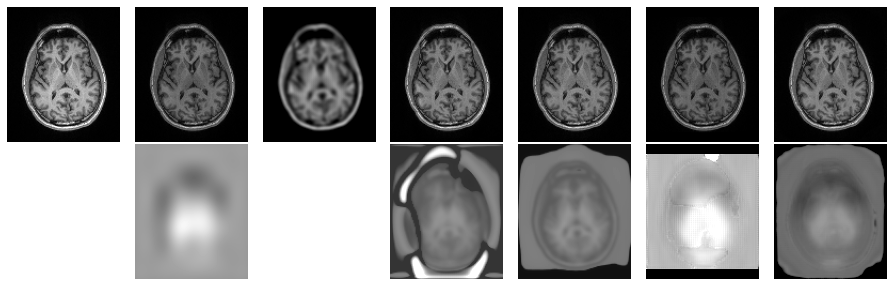

In [89]:

def plot_slices(image,i, r):#, mask):
    slice_idx = 60
    #image = np.where(mask, image,0)
    root = '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all_noguass/'
    image = nib.load(root + image).get_fdata()
    slice = image
    slice = image[:,:,np.int32(slice.shape[2] / 1.7)]
    slice = np.flip(np.rot90(slice,3))
    slice = np.nan_to_num(slice)
    if i > 7:
        i = i + 1
    plt.subplot(2,7,i)
    plt.axis('off')
    cmap = plt.get_cmap('gray')
    m = r[0]
    M = r[1]
    im = plt.imshow(slice, vmin=m, vmax=M, cmap=cmap)
    print(i, slice.max(), slice.min())
    # divider = make_axes_locatable(plt.gca())
    # ax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar()

fig, axes = plt.subplots(2,5, figsize=(16,5))
plt.rcParams.update({'font.size':15})


r = [ (0,483),(0,483), (0,483), (0,483), (0,483), (0,483), (0,483),
        (0.89,1.82), (-1000,-1), (0.89,1.82), (0.89,1.82), (0.89,1.82), (0.89,1.82)]

for i in range(13):
    plot_slices(d[i], i+1, r[i])

plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [176]:
from scipy.stats import pearsonr
corr, _ = pearsonr(a,b)
print('Pearsons correlation: %.3f' % corr)

NameError: name 'b' is not defined

In [74]:
# for colorbar
def plot_slice(image,i):
    slice_idx = 60
    # image = nib.load( '/nfs/masi/kanakap/projects/DeepN4/src/unet_trained_model_all_noguass/' + image).get_fdata()
    image = nib.load('/home/local/VANDERBILT/kanakap/deepN4_data/inputs/sub-2018_ses-adni3baselinescanner031_T1w.nii.gz').get_fdata()
    slice = image[slice_idx, :,:]
    slice = np.flip(np.rot90(slice,3))
    slice = np.nan_to_num(slice)
    plt.subplot(3,5,i)
    plt.axis('off')
    cmap = plt.get_cmap('gray')
    # m = 0.89
    # M = 1.82
    im = plt.imshow(slice, cmap=cmap)
    print()
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="3%", pad=0.10)
    a = plt.colorbar(im, cax=cax)

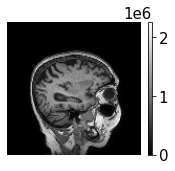

In [75]:
# for colorbar
fig = plt.figure(figsize=(15,10))
for i in range(1):
    plot_slice(d[i], i+1)

In [115]:
input1.shape

(106, 127, 135)

In [132]:
import numpy as np
from scipy import signal

def log_gabor_3d(image, frequency, theta, bandwidth):
    # Create 3D Gabor filter
    sigma = bandwidth / (2 * np.pi)
    x, y, z = np.meshgrid(range(image.shape[0]), range(image.shape[1]), range(image.shape[2]))
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    gb = np.exp(-((x_theta**2 + y_theta**2) / (2 * sigma**2)) - np.log2(np.sqrt(2) * sigma)) * np.cos(2 * np.pi * frequency * z)
    # Apply filter to image
    filtered_image = signal.convolve(image, gb, mode='same')
    return filtered_image

In [133]:
filtered_image = log_gabor_3d(input1, frequency=0.5, theta=np.pi/4, bandwidth=0.1)

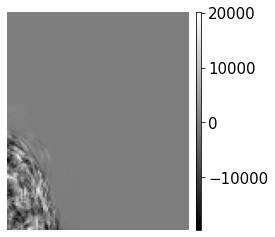

In [134]:
image = filtered_image
slice = image[:, :,60]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.axis('off')
cmap = plt.get_cmap('gray')
# m = 0.89
# M = 1.82
im = plt.imshow(slice, cmap=cmap)
print()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="3%", pad=0.10)
a = plt.colorbar(im, cax=cax)

In [147]:
import scipy
def log_gabor_3d(shape, sigma, frequency, theta, phi):
    sigma_x = sigma[0]
    sigma_y = sigma[1]
    sigma_z = sigma[2]
    (x, y, z) = np.meshgrid(range(shape[0]), range(shape[1]), range(shape[2]), indexing='ij')
    x = x - shape[0]//2
    y = y - shape[1]//2
    z = z - shape[2]//2
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    z_phi = z * np.cos(phi) + y_theta * np.sin(phi)
    y_phi = -z * np.sin(phi) + y_theta * np.cos(phi)
    gb = np.exp(-0.5 * (x_theta**2/sigma_x**2 + y_phi**2/sigma_y**2 + z_phi**2/sigma_z**2)) * np.cos(2*np.pi*frequency*x_theta)
    return gb

shape = (4,4,4)
sigma = (8, 8, 8)
frequency = 0.1
theta = np.pi/4
phi = np.pi/4
gb = log_gabor_3d(shape, sigma, frequency, theta, phi)
filtered_image = scipy.ndimage.convolve(input1, gb, mode='constant', cval=1.0)

In [197]:
import numpy as np
from scipy import signal

def loggabor3d(shape, sigma, frequency, theta, phi):
    """
    Create a 3D log-Gabor filter with the specified shape, standard deviation,
    frequency, orientation, and phase.
    """
    sigma_x = sigma[0]
    sigma_y = sigma[1]
    sigma_z = sigma[2]
    
    # Create 3D meshgrid
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    
    # Convert x, y, z to spherical coordinates
    rho = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / rho)
    
    # Rotate coordinates by the specified angle
    theta = theta - theta
    phi = phi - phi
    
    # Convert back to Cartesian coordinates
    x = rho * np.sin(theta) * np.cos(phi)
    y = rho * np.sin(theta) * np.sin(phi)
    z = rho * np.cos(theta)
    
    # Compute the log-Gabor filter
    loggabor = np.exp(-0.5 * ((x / sigma_x)**2 + (y / sigma_y)**2 + (z / sigma_z)**2)) * np.cos(2 * np.pi * frequency * x + phi)
    
    return loggabor

# Test the loggabor3d function
theta = 0
phi = 0
loggabor = loggabor3d((24,24,24), (4, 4, 4), 0, theta, phi)
filtered_image1 = scipy.ndimage.convolve(input1, loggabor)
loggabor = loggabor3d((16,16,16), (4, 4, 4), 0, theta, phi)
filtered_image2 = scipy.ndimage.convolve(input1, loggabor)
loggabor = loggabor3d((8,8,8), (4, 4, 4), 0, theta, phi)
filtered_image3 = scipy.ndimage.convolve(input1, loggabor)


/tmp/ipykernel_2024688/2212633545.py:19: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(z / rho)


In [194]:
filtered_image1.shape

(106, 127, 135)

In [193]:
input1.shape

(106, 127, 135)

79
79
79


/tmp/ipykernel_2024688/3885144653.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


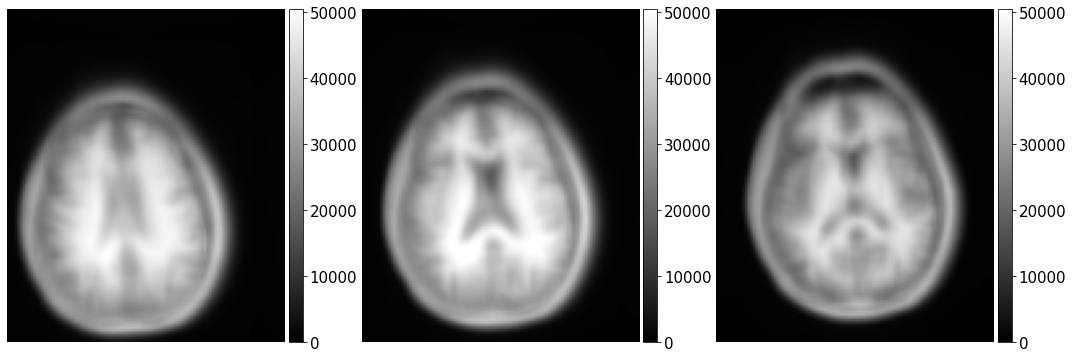

In [200]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(18,8))

slice = filtered_image1
print(np.int32(slice.shape[2] / 1.7))
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,3,1)
plt.axis('off')
m = 0
M = np.max(slice)
im = plt.imshow(np.abs(slice),vmin=m, vmax=M,  cmap='gray')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = filtered_image2
print(np.int32(slice.shape[2] / 1.7))
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,3,2)
plt.axis('off')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap='gray')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

slice = filtered_image3
print(np.int32(slice.shape[2] / 1.7))
slice = slice[:,:,np.int32(slice.shape[2] / 1.7)]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)

plt.subplot(1,3,3)
plt.axis('off')
im = plt.imshow(np.abs(slice), vmin=m, vmax=M,  cmap='gray')
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)



In [202]:
torch.Tensor(filtered_image1[np.newaxis,np.newaxis,...]).shape

torch.Size([1, 1, 106, 127, 135])

In [223]:
with open('_cbtrain_100ds.csv', 'r') as f:
     for line in f:
          inputfile = line.split(',')[1]
          img = nib.load(inputfile)
          data = img.get_fdata()
          # filter
          output_file1 = '/home/local/VANDERBILT/kanakap/deepN4_data/filtered1/' + inputfile.split('/')[-1]
          output_file2 = '/home/local/VANDERBILT/kanakap/deepN4_data/filtered2/' + inputfile.split('/')[-1]
          output_file3 = '/home/local/VANDERBILT/kanakap/deepN4_data/filtered3/' + inputfile.split('/')[-1]
          # save the image 
          nii1 = nib.Nifti1Image(filtered_image1, affine=img.affine, header=img.header)
          nib.save(nii1, output_file1)

          nii2 = nib.Nifti1Image(filtered_image2, affine=img.affine, header=img.header)
          nib.save(nii2, output_file2)

          nii3 = nib.Nifti1Image(filtered_image3, affine=img.affine, header=img.header)
          nib.save(nii3, output_file3)

          # write to training csv list 
          with open('_rnet_train.csv','w') as p:
               bias_file = '/home/local/VANDERBILT/kanakap/deepN4_data/bias/' + inputfile.split('/')[-1]
               correct_file = '/home/local/VANDERBILT/kanakap/deepN4_data/labels/' + inputfile.split('/')[-1]
               p.write("%s,%s,%s,%s,%s,%s\n" % (correct_file,inputfile,bias_file,output_file1,output_file2,output_file3))
               




KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the 3D image data
image_data = input1

# Extract the x, y, and z dimensions of the image
nx, ny, nz = image_data.shape

# Create a figure and an Axes3D object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create an array of coordinates for the pixels in the image
X, Y, Z = np.meshgrid(range(nx), range(ny), range(nz))

# Plot the pixel intensities as a 3D surface plot
ax.plot_surface(X, Y, Z, cmap='gray', facecolors=image_data)

plt.show()